# PyTorch - Introduction - Simple Image Classifier

In this notebook, we will try to build a simple image classifier on the CIFAR-10 dataset. Our goal in this notebook is not to get state of the art accuracies but rather, to become comfortable with pytorch.

The CIFAR-10 dataset has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

This notebook will just be an imitation of the wonderful tutorial at the PyTorch docs itself.

Reference : http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Imports




In [51]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

%matplotlib inline

The torchvision package has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., *torchvision.datasets* and *torch.utils.data.DataLoader*. The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

Now, one of the cool things about PyTorch is that we can create a set of transformations. While loading the dataset using torchvision, we can then specify these and the data would be transformed accordingly.

Reference : http://pytorch.org/docs/master/torchvision/transforms.html

Reference : http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader

In [39]:
PATH = 'data/CIFAR10/'
RESULTS = PATH + 'results/'
MODELS = PATH + 'models/'

In [21]:
transformations = transforms.Compose( [ transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5) ) ]  )

trainset = torchvision.datasets.CIFAR10(root=PATH, download=True, train=True,transform=transformations)

trainLoader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=32, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=PATH, download=True, train=False,transform=transformations)

testLoader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=32, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Data Exploration

Now that we know how to download and transform the dataset in such a simple manner, let us see a few examples from the dataset.

In [92]:
def imshow(img):
    
    img = img*0.5 + 0.5 #unnormalize the data first
    
    # To convert a torch tensor to a numpy array, we just call .numpy on the tensor
    
    img = img.numpy()
    
    # Now the image is format (#channels, height, width)
    # For tensorflow, the channel should appear at the last
    
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.plot()

In [93]:
dataiter = iter(trainLoader)
images, labels = dataiter.next()

In [94]:
images[0].shape

torch.Size([3, 32, 32])

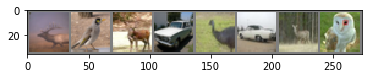

In [95]:
imshow(torchvision.utils.make_grid(images[:8]))

In [96]:
' '.join(classes[label] for label in labels[:8])

'deer bird deer car bird car deer bird'

## Model Creation

What we will be doing to create the network is to create a subclass of torch.nn.Module.

When subclassing torch.nn.Module, 2 functions need to be implemented:

* **__init__** function has to first call the parents __init__ method. We can then define parameters of the layer here as the class variables i.e. self.x

* **forward** funtion is where we pass an input through the layer, perform operations on inputs using parameters and return the output. The input needs to be an autograd.Variable() so that pytorch can build the computational graph of the layer.

Reference : https://hsaghir.github.io/data_science/pytorch_starter/

Here are some references to the layers we will be using : 

Reference : http://pytorch.org/docs/master/nn.html#torch.nn.Conv2d

Reference : http://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d

Reference : http://pytorch.org/docs/master/nn.html#torch.nn.Linear

**NOTE**

There is no padding by default in PyTorch Conv2d layers. The convolutions are 'valid' by deafult and this we might lose some of the last columns of the input. It is left to the user to provide proper padding if needed.

### Create Network

In [189]:
class CNN(nn.Module):

    def __init__(self):
        
        super(CNN,self).__init__()
        
        # we are working with RGB images, so we will have 3 input channels to the first conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,5))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        #output of previous row and input of next row should be same
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5))
        
        self.fc1 = nn.Linear(in_features=128*5*5, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=60)
        
        #Last fully connected layer has output of 10 since we have 10 classes
        self.fc3 = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Before passing the output to the linear layers, we will need to flatten the output of previous layer
        
        x = x.view(-1, self.num_of_flattened_features(x))
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x
    
    def num_of_flattened_features(self, x):
        shape = x.size()[1:] # The first dimension is just the batch size
        n = 1
        
        for s in shape:
            n = n*s
        
        return n

The .cuda() method will transfer the build network onto the GPU

In [190]:
cnn_model = CNN().cuda()

In [191]:
print(cnn_model)

CNN(
  (conv1): Conv2d (3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=600)
  (fc2): Linear(in_features=600, out_features=60)
  (fc3): Linear(in_features=60, out_features=10)
)


In [192]:
params = list(cnn_model.parameters())
print("Number of parameters are : " + str(len(params)))

for param in params:
    print(param.size())

Number of parameters are : 10
torch.Size([64, 3, 5, 5])
torch.Size([64])
torch.Size([128, 64, 5, 5])
torch.Size([128])
torch.Size([600, 3200])
torch.Size([600])
torch.Size([60, 600])
torch.Size([60])
torch.Size([10, 60])
torch.Size([10])


### Define Loss Function and Optimizer

We will be using the cross entropy loss since are are training a multi-class classifier. Also, for optimization, we will be using Stochastic Gradient Descent.

Reference : http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss

Reference : http://pytorch.org/docs/master/optim.html#torch.optim.SGD

In [193]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(cnn_model.parameters(), lr=1e-4, momentum=0.9)

### Training The Network

Now we are ready to start training the model. We will be training our model over a few epochs. In each epoch, here are the steps we will be doing  :

    * Loop over the DataLoader for the training set, here trainLoader, and get the images and labels a batch at a time.
    * Compute a forward pass over the Network to get the outputs
    * Feed the targets, i.e. the labels and the outputs to the loss function we had above
    * Do a backward pass over the Network
    * Perform an optimazation step

Reference : http://pytorch.org/docs/master/optim.html#how-to-use-an-optimizer

In [194]:
epochs = 2

In [195]:
for epoch in range(epochs):
    
    for i, data in enumerate(trainLoader,1): # the second argument 1, makes i start from 1 instead of zero
        
        # Get the inputs
        img, label = data
        
        # Wrap them in Variables and call .cuda() to load them on GPU
        
        img  =  Variable(img.cuda()) 
        label = Variable(label.cuda())
        
        # We need to clear the existing gradients, else gradients will be accumulated to existing gradients
        optimizer.zero_grad()
        
        output = cnn_model(img)           # Forward pass to compute the output
        curr_loss = loss_fn(output,label) # Compute loss function
        curr_loss.backward()              # Backward pass to compute the gradients
        optimizer.step()                  # Optimize weights to reduce loss
        
        running_loss = curr_loss.data[0]
        
        if i%200 == 0 :                # for every 2000 mini-bacthes
            print("Epoch : "+str(epoch+1) + "| Batches done : " + str(i))
            print("Loss is : "  +str(running_loss/2000))
            print()
            running_loss = 0
            
            

Epoch : 1| Batches done : 200
Loss is : 0.0011489648818969727

Epoch : 1| Batches done : 400
Loss is : 0.001140293002128601

Epoch : 1| Batches done : 600
Loss is : 0.0011495072841644287

Epoch : 1| Batches done : 800
Loss is : 0.0011521855592727661

Epoch : 1| Batches done : 1000
Loss is : 0.00114233660697937

Epoch : 1| Batches done : 1200
Loss is : 0.0011353874206542968

Epoch : 1| Batches done : 1400
Loss is : 0.0011483545303344726

Epoch : 2| Batches done : 200
Loss is : 0.0011377419233322143

Epoch : 2| Batches done : 400
Loss is : 0.0011387569904327392

Epoch : 2| Batches done : 600
Loss is : 0.0011455599069595337

Epoch : 2| Batches done : 800
Loss is : 0.0011269819736480712

Epoch : 2| Batches done : 1000
Loss is : 0.0011237307786941529

Epoch : 2| Batches done : 1200
Loss is : 0.0011267271041870118

Epoch : 2| Batches done : 1400
Loss is : 0.001125049352645874



### Testing The Network

Now that we are done with training the network, we can start using it. Let us test it on our test dataset.

Let us look at a few images from the test set.

In [196]:
dataiter = iter(testLoader)
images, labels = dataiter.next()

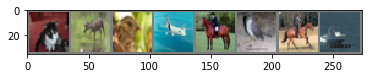

In [197]:
imshow(torchvision.utils.make_grid(images[:8]))

In [198]:
' '.join(classes[label] for label in labels[:8])

'cat deer bird plane horse bird horse ship'

In [199]:
preds = cnn_model(Variable(images.cuda()))

In [200]:
preds.shape

torch.Size([32, 10])

The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:



In [201]:
_, predicted = torch.max(preds.data,1)

In [202]:
' '.join(classes[predicted[j]] for j in range(8))

'frog frog frog ship frog dog frog frog'

In [203]:
labels.size(0)

32

Let us see its performance on the whole test set.

In [204]:
correct = 0
total = 0

for data in testLoader:
    img, label = data
    
    img  =  Variable(img).cuda() 
    label = label.cuda()
    
    pred = cnn_model(img)
    _, predictions = torch.max(pred.data,1)
    
    total = total + label.size(0)
    
    curr_correct = (predictions == label).sum()
    
    correct = correct + curr_correct

In [205]:
correct, total

(2317, 10000)

In [206]:
print("Accuracy is : " + str(100*correct/total))

Accuracy is : 23.17
